In [4]:
import re

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpt
import seaborn as sns
import joblib
import warnings

In [6]:
from sklearn.model_selection import train_test_split , cross_val_score , StratifiedGroupKFold

In [7]:
from sklearn.pipeline import Pipeline

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
from sklearn.dummy import DummyClassifier

In [10]:
from sklearn.naive_bayes import MultinomialNB

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
from sklearn.svm import LinearSVC

In [13]:
from sklearn.metrics import ( accuracy_score , precision_score , recall_score , f1_score , classification_report, confusion_matrix , ConfusionMatrixDisplay)

In [14]:
warnings.filterwarnings("ignore" , category=FutureWarning)

In [15]:
np.random.seed(42)

In [16]:
RANDOM_STATE = 42

In [17]:
# treat spam as positive class for precision/recall/f1 reporting 
POS_LABEL = "spam"

In [39]:
url = r"C:\Users\HP\Desktop\projectsss\Spam-Mail-Detector\enron_spam_data.csv"
df = pd.read_csv(url, encoding="latin-1")
df.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [21]:
# inspect & basi cleaning: unify text field and labels
# check columns
print("Columns: ",df.columns.tolist())

Columns:  ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']


In [40]:
for col in ["label" , "Label" , "message", "Message" , "subject" , "Subject" , "text" , "Text"]:
    if col in df.columns:
        print("Found column: ", col)

Found column:  Message
Found column:  Subject


In [41]:
# creating a single 'text' column combining subject+message

if "Subject" in df.columns and "Message" in df.columns:
    df["text"] = df["Subject"].fillna("") + " " + df["Message"].fillna("")
elif "subject" in df.columns and "message" in df.columns:
    df["text"] = df["subject"].fillna("") + " " + df["message"].fillna("")
elif "Message" in df.columns:
    df["text"] = df["Message"].astype(str)
elif "message" in df.columns:
    df["text"] = df["message"].astype(str)
elif "text" in df.columns:
    df["text"] = df["text"].astype(str)
else:
    display(df.head(3))
    raise ValueError("Couldn't find email text columns; check CSV column names.")

In [42]:
# normalize label column to lower-case 'spam'/'ham'
if "Spam/Ham" in df.columns:
    df["label"] = df["Spam/Ham"].astype(str).str.lower().str.strip()
elif "label" in df.columns:
    df["label"] = df["label"].astype(str).str.lower().str.strip()
elif "Label" in df.columns:
    df["label"] = df["Label"].astype(str).str.lower().str.strip()
else:
    raise ValueError("Couldn't find label column; check CSV.")
        

In [43]:
# keep only spam/ham rows
df = df[df["label"].isin(["spam", "ham"])].copy()
df = df.dropna(subset=["text"])
df.reset_index(drop=True, inplace=True)

In [44]:
print("Rows after cleaning:", len(df))
print(df["label"].value_counts())

Rows after cleaning: 33716
label
spam    17171
ham     16545
Name: count, dtype: int64


In [45]:
# lightweight EDA (class balance & text length)

df["text_len"] = df["text"].str.len() # add a text length column

In [46]:
print(df["label"].value_counts()) # check class balance

label
spam    17171
ham     16545
Name: count, dtype: int64


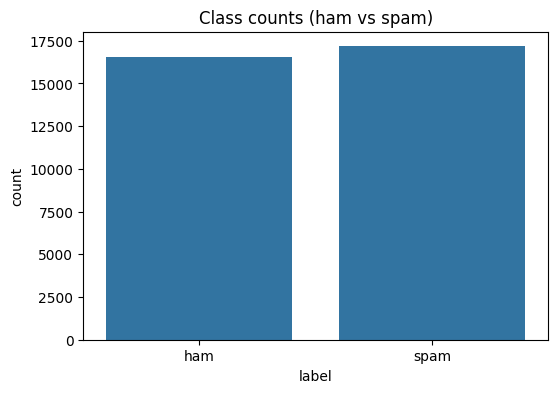

In [47]:
mpt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
mpt.title("Class counts (ham vs spam)")
mpt.show()

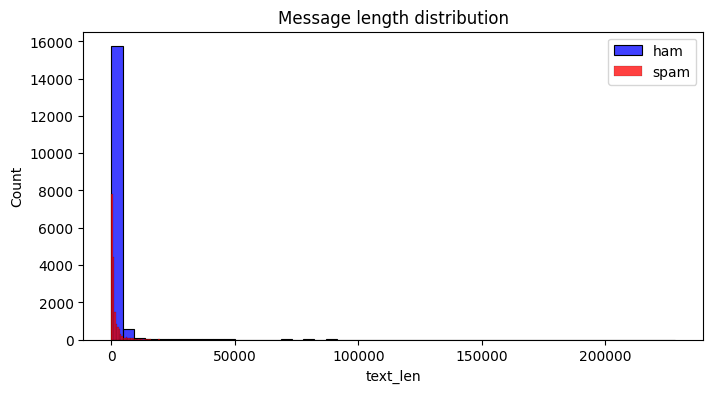

In [48]:
mpt.figure(figsize=(8,4))
sns.histplot(df[df["label"]=="ham"]["text_len"], label="ham", kde=False, bins=50, color="blue")
sns.histplot(df[df["label"]=="spam"]["text_len"], label="spam", kde=False, bins=50, color="red")
mpt.legend()
mpt.title("Message length distribution")
mpt.show()

In [49]:
def simple_clean(text):
    t = str(text)
    
    t = re.sub(r"http\S+|www\.\S+", " ", t) # remove URLs
    
    t = re.sub(r"\S+@\S+", " ", t) # remove email addresses
    
    t = re.sub(r"\d+", " ", t) # remove numbers
    
    t = re.sub(r"[^\w\s]", " ", t) # remove special characters (keep only alphanumeric and spaces)
    
    t = re.sub(r"\s+", " ", t).strip().lower()  # collapse whitespace, lowercase
    return t

In [50]:
# Apply cleaning to your text column
df["clean_text"] = df["text"].apply(simple_clean)


In [51]:
print(simple_clean("Hello! Visit https://example.com or mail me at john@example.com. Price: $1000"))
print(df[["text", "clean_text"]].head())  # check cleaned results

hello visit or mail me at price
                                                text  \
0                      christmas tree farm pictures    
1  vastar resources , inc . gary , production fro...   
2  calpine daily gas nomination - calpine daily g...   
3  re : issue fyi - see note below - already done...   
4  meter 7268 nov allocation fyi .\n- - - - - - -...   

                                          clean_text  
0                       christmas tree farm pictures  
1  vastar resources inc gary production from the ...  
2  calpine daily gas nomination calpine daily gas...  
3  re issue fyi see note below already done stell...  
4  meter nov allocation fyi forwarded by lauri a ...  


In [52]:
# prepare X, y, and train/test split (stratified)
X = df["clean_text"].values   # use pre-cleaned text
y = df["label"].values

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [54]:
print("Train / Test sizes:", len(X_train), len(X_test))
print("Class distribution in y_train:", pd.Series(y_train).value_counts(normalize=True))
print("Class distribution in y_test:", pd.Series(y_test).value_counts(normalize=True))

Train / Test sizes: 26972 6744
Class distribution in y_train: spam    0.509269
ham     0.490731
Name: proportion, dtype: float64
Class distribution in y_test: spam    0.509342
ham     0.490658
Name: proportion, dtype: float64


In [56]:
# Helper: evaluation function
def eval_print(name, model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, pos_label=POS_LABEL, zero_division=0)
    rec = recall_score(y_test, preds, pos_label=POS_LABEL, zero_division=0)
    f1 = f1_score(y_test, preds, pos_label=POS_LABEL, zero_division=0)
    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 (spam): {f1:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, preds, zero_division=0))
    # confusion matrix
    cm = confusion_matrix(y_test, preds, labels=["ham","spam"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham","spam"])
    fig, ax = mpt.subplots(figsize=(4,3))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    mpt.title(f"Confusion Matrix: {name}")
    mpt.show()
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1}



=== Baseline (most frequent) ===
Accuracy:  0.509
Precision: 0.509
Recall:    1.000
F1 (spam): 0.675

Classification Report:
              precision    recall  f1-score   support

         ham       0.00      0.00      0.00      3309
        spam       0.51      1.00      0.67      3435

    accuracy                           0.51      6744
   macro avg       0.25      0.50      0.34      6744
weighted avg       0.26      0.51      0.34      6744



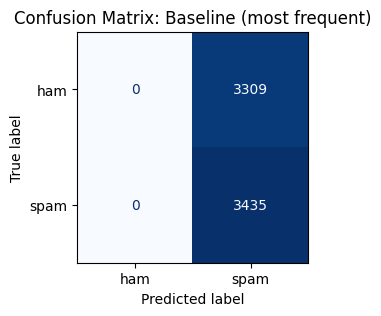

In [57]:
# Baseline: predict the most frequent class
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
baseline.fit(X_train.reshape(-1,1), y_train)  # Dummy doesn't use X, but requires 2D
baseline_metrics = eval_print("Baseline (most frequent)", baseline, X_test.reshape(-1,1), y_test)

In [58]:
pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=simple_clean,
        stop_words="english",
        ngram_range=(1,2),   # unigrams + bigrams
        min_df=3,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("clf", MultinomialNB())
])



=== TF-IDF + MultinomialNB ===
Accuracy:  0.993
Precision: 0.992
Recall:    0.994
F1 (spam): 0.993

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      3309
        spam       0.99      0.99      0.99      3435

    accuracy                           0.99      6744
   macro avg       0.99      0.99      0.99      6744
weighted avg       0.99      0.99      0.99      6744



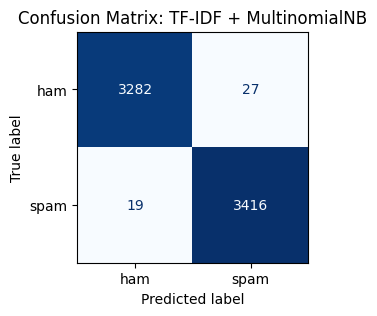

In [59]:
pipe_nb.fit(X_train, y_train)
nb_metrics = eval_print("TF-IDF + MultinomialNB", pipe_nb, X_test, y_test)

In [60]:
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=simple_clean,
        stop_words="english",
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))
])


=== TF-IDF + LogisticRegression ===
Accuracy:  0.991
Precision: 0.986
Recall:    0.997
F1 (spam): 0.991

Classification Report:
              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      3309
        spam       0.99      1.00      0.99      3435

    accuracy                           0.99      6744
   macro avg       0.99      0.99      0.99      6744
weighted avg       0.99      0.99      0.99      6744



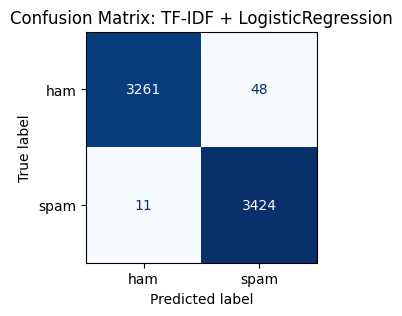

In [61]:
pipe_lr.fit(X_train, y_train)
lr_metrics = eval_print("TF-IDF + LogisticRegression", pipe_lr, X_test, y_test)

In [62]:
pipe_svc = Pipeline([
    ("tfidf", TfidfVectorizer(preprocessor=simple_clean, stop_words="english", ngram_range=(1,2), min_df=3)),
    ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
])


=== TF-IDF + LinearSVC ===
Accuracy:  0.995
Precision: 0.992
Recall:    0.997
F1 (spam): 0.995

Classification Report:
              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      3309
        spam       0.99      1.00      0.99      3435

    accuracy                           0.99      6744
   macro avg       0.99      0.99      0.99      6744
weighted avg       0.99      0.99      0.99      6744



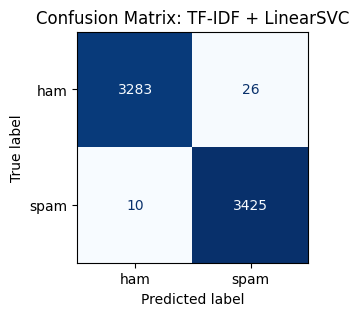

In [63]:
pipe_svc.fit(X_train, y_train)
svc_metrics = eval_print("TF-IDF + LinearSVC", pipe_svc, X_test, y_test)

In [64]:
models_for_cv = {
    "NB": pipe_nb,
    "LR": pipe_lr,
    "SVC": pipe_svc
}

In [66]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [67]:
print("Cross-validation (F1 for spam):")
for name, model in models_for_cv.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)
    print(f"{name}: mean F1 = {scores.mean():.3f}, std = {scores.std():.3f}")

Cross-validation (F1 for spam):
NB: mean F1 = nan, std = nan
LR: mean F1 = nan, std = nan
SVC: mean F1 = nan, std = nan


In [68]:
# get predicted probabilities for 'spam'
proba = pipe_lr.predict_proba(X_test)  # shape (n_samples, 2)
spam_idx = list(pipe_lr.classes_).index("spam")
p_spam = proba[:, spam_idx]

In [69]:
best = {"threshold": 0.5, "f1": -1}

In [70]:
for thr in np.linspace(0.1, 0.9, 17):
    preds_thr = np.where(p_spam >= thr, "spam", "ham")
    f1 = f1_score(y_test, preds_thr, pos_label="spam", zero_division=0)
    if f1 > best["f1"]:
        best = {"threshold": float(thr), "f1": float(f1)}

In [71]:
print("Best threshold by F1 for LR:", best)

Best threshold by F1 for LR: {'threshold': 0.6, 'f1': 0.9933081175443701}


              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      3309
        spam       0.99      0.99      0.99      3435

    accuracy                           0.99      6744
   macro avg       0.99      0.99      0.99      6744
weighted avg       0.99      0.99      0.99      6744



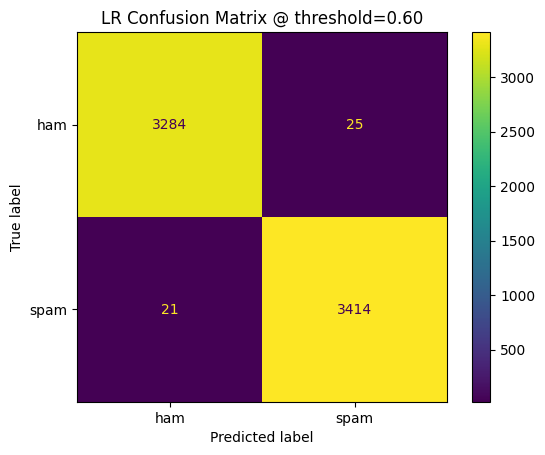

In [72]:
# visualize at best threshold
preds_thr = np.where(p_spam >= best["threshold"], "spam", "ham")
print(classification_report(y_test, preds_thr, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_test, preds_thr, display_labels=["ham","spam"])
mpt.title(f"LR Confusion Matrix @ threshold={best['threshold']:.2f}")
mpt.show()

In [73]:
# Get TF-IDF vocabulary & feature names from the TF-IDF step (use LR or NB pipe)
tfidf = pipe_lr.named_steps["tfidf"]
clf_lr = pipe_lr.named_steps["clf"]
feature_names = tfidf.get_feature_names_out()

In [74]:
# top positive (spam) and negative (ham) coefficients in LR
coefs = clf_lr.coef_[0]  # LR binary: shape (1, n_features) if classes are [ham, spam] or similar
idx_sorted = np.argsort(coefs)
top_ham = idx_sorted[:10]        # most negative coefficients (indicative of ham)
top_spam = idx_sorted[-10:]      # most positive coefficients (indicative of spam)

In [75]:
print("Top words indicative of HAM:")
for i in top_ham[::-1]:
    print(feature_names[i], round(coefs[i], 3))

Top words indicative of HAM:
let know -4.808
enron com -4.865
meeting -5.176
gas -5.558
louise -6.053
questions -6.117
vince -7.3
thanks -7.884
attached -8.199
enron -13.904


In [76]:
print("\nTop words indicative of SPAM:")
for i in top_spam[::-1]:
    print(feature_names[i], round(coefs[i], 3))


Top words indicative of SPAM:
http 5.079
money 4.41
online 3.967
life 3.953
software 3.714
click 3.546
save 3.164
account 3.096
man 2.991
viagra 2.909


In [77]:
all_metrics = {
    "Baseline": baseline_metrics,
    "NB": nb_metrics,
    "LR": lr_metrics,
    "SVC": svc_metrics
}

In [78]:
summary = pd.DataFrame.from_dict(all_metrics, orient="index")
display(summary[["accuracy","precision","recall","f1"]])

,accuracy,precision,recall,f1
Baseline,0.509342,0.509342,1.000000,0.674919
NB,0.993179,0.992158,0.994469,0.993312
LR,0.991251,0.986175,0.996798,0.991458
SVC,0.994662,0.992466,0.997089,0.994772


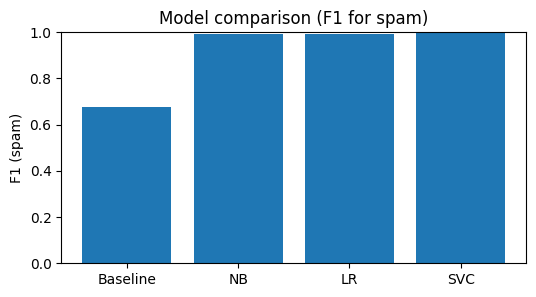

In [79]:
# Bar chart of F1 scores
mpt.figure(figsize=(6,3))
mpt.bar(summary.index, summary["f1"])
mpt.title("Model comparison (F1 for spam)")
mpt.ylabel("F1 (spam)")
mpt.ylim(0,1)
mpt.show()

In [80]:
# choose best by F1 here:
best_name = summary["f1"].idxmax()
print("Best model by F1:", best_name)

Best model by F1: SVC


In [81]:
# map name -> pipeline object
model_map = {"NB": pipe_nb, "LR": pipe_lr, "SVC": pipe_svc}
if best_name in model_map:
    best_model_obj = model_map[best_name]
    joblib.dump(best_model_obj, "best_spam_model.joblib")
    print("Saved best model as best_spam_model.joblib")
else:
    print("Baseline was best (unlikely).")

Saved best model as best_spam_model.joblib
